In [1]:
import pyspark,pandas,ogr

### matplotlib，用于可视化的，myFont用于处理中文编码的

In [2]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import *
myfont = FontProperties(fname='/usr/share/fonts/wqy-zenhei/wqy-zenhei.ttc')

In [3]:
from h3 import h3

In [4]:
conf = pyspark.SparkConf().setMaster("spark://192.168.72.152:7077")

In [5]:
sc = pyspark.SparkContext(conf=conf)

## 从HDFS上读取数据，从20世纪40年代开始，共计70多年的地震数据

In [6]:
rdd = sc.textFile("hdfs://192.168.72.152:8020/data/eq/eq.csv")

## 共计有162万多条

In [7]:
rdd.count()

1627923

In [8]:
rdd.take(4)

['FID,date,time,x,y,s,lv,i3',
 '0,1997/12/31 0:00:00,00:00:55,92.489999999999995,11.100000000000000,33,4.100000000000000, ',
 '1,1997/12/31 0:00:00,00:00:56,92.469999999999999,11.080000000000000,30,4.000000000000000, ',
 '2,1997/12/31 0:00:00,00:00:53,92.500000000000000,11.100000000000000,21,4.100000000000000,Andaman Islands region']

In [9]:
def isPoint(line):
    pntline = line.split(",")
    try:
        wkt = "POINT({0} {1})".format(float(pntline[3]),
                                      float(pntline[4]))
        return ogr.CreateGeometryFromWkt(wkt).IsValid()
    except:
        return False

In [10]:
eqrdd = rdd.filter(lambda line:isPoint(line))

## < 60公里：浅源地震
## 60 < x < 300 中源地震
## > 300 深源地震

In [11]:
def mymap(line):
    eq = line.split(",")
    tp = "shallow"
    if float(eq[5]) > 60 and float(eq[5]) < 300:
        tp = "Intermediate"
    elif float(eq[5]) > 300:
        tp = "palintectic"
    h3code = h3.geo_to_h3(float(eq[4]),float(eq[3]),1)
    return ("{0}_{1}".format(tp,h3code),1)

In [12]:
res = eqrdd.map(lambda line : mymap(line)).reduceByKey(lambda x,y:x+y).collect()

In [13]:
res[:10]

[('shallow_814b3ffffffffff', 2316),
 ('shallow_811efffffffffff', 67459),
 ('Intermediate_81dabffffffffff', 1813),
 ('shallow_816d7ffffffffff', 10820),
 ('shallow_81737ffffffffff', 4867),
 ('Intermediate_81737ffffffffff', 1854),
 ('shallow_81073ffffffffff', 2740),
 ('shallow_812ebffffffffff', 28694),
 ('shallow_81163ffffffffff', 14481),
 ('shallow_817a7ffffffffff', 469)]

## 用Pandas包来处理，省事

In [14]:
pd = []
for r in res:
    val = {}
    key = r[0].split("_")
    val["eqtype"] = key[0]
    val["cood"] = h3.h3_to_geo_boundary(key[1])
    val["num"] = r[1]
    pd.append(val)

In [15]:
eqpd = pandas.DataFrame(pd)

In [16]:
eqpd.head(10)

,cood,eqtype,num
0,"[[29.89298533869355, 120.503393859958], [26.20...",shallow,2316
1,"[[44.47067958889503, 18.314740441318996], [39....",shallow,67459
2,"[[-45.286766294393956, 176.12935250330446], [-...",Intermediate,1813
3,"[[14.4654560154265, -89.86490654761025], [10.9...",shallow,10820
4,"[[13.866921861790896, 136.4065502724283], [9.2...",shallow,4867
5,"[[13.866921861790896, 136.4065502724283], [9.2...",Intermediate,1854
6,"[[73.31022368544396, 0.32561035194326043], [75...",shallow,2740
7,"[[45.62266462732751, 152.54480605394903], [49....",shallow,28694
8,"[[56.96070015239116, 156.27850722494344], [54....",shallow,14481
9,"[[-2.043983130098265, 41.58665495463515], [2.3...",shallow,469


## 做一个柱状图统计一下

### 可以发现，主要是浅源地震，其次在中源

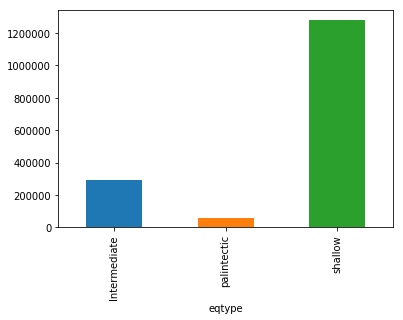

In [17]:
eqpd.groupby("eqtype")["num"].sum().plot(kind='bar')

## 下面几个方法都是用来做可视化的，这个是处理不同数据量颜色列表的方法

In [18]:
def getColorByList(colName, valList):
    cm = plt.cm.get_cmap(colName)
    news_ids = list(set(valList))
    news_ids.sort()
    col = [cm(float(i)/(len(news_ids))) for i in range(len(news_ids))]
    cols = {}
    for i in range(len(col)):
        c = col[i]
        v = news_ids[i]
        t = [int(c[0]*255), int(c[1]*255), int(c[2]*255), int(c[3]*255)]
        hl = "#"
        for i in t:
            h = "{0}".format(hex(i))[2:]
            if len(h)<= 1:
                h = "0{0}".format(h)
            hl+=h
        cols[v] = hl
    return cols
collist = getColorByList(plt.cm.jet,eqpd["num"].tolist())

## 处理超限数据，主要是地球是圆的，平铺之后会出现首尾相连

In [19]:
def isOverrun(pl):
    x = [xy[0] for xy in pl]
    xmin = min(x)
    xmax = max(x)
    if xmax - xmin < 100:
        return False 
    else:
        return True
def show(polyArr,title="地震蜂窝六边形聚合专题图"):  
    fig = plt.figure(figsize=(12,9)) 
    wordmap = plt.imread("./img/world.jpg")
    plt.imshow(wordmap, zorder=0, extent=[-179.99,179.999,-89.999,89.9999])
    ax = fig.gca() 
    ax.grid(alpha= 1)
    for i in range(len(polyArr)):
        pl = polyArr[i][0]
        num = polyArr[i][1]
        if isOverrun(pl):
            pass
        else:
            if num > 100:
                mpoly = plt.Polygon(pl,ec = '#000000',fc=collist[num], alpha = 0.5)
                ax.add_patch(mpoly)
    ax.set_autoscale_on= False
    ax.set_xlim(-179,179)
    ax.set_ylim(-89,89)
    ax.set_title(title,color='r',fontproperties=myfont,fontsize=18)
    plt.show()

# 查看大于爆发过超过100次地震的区域

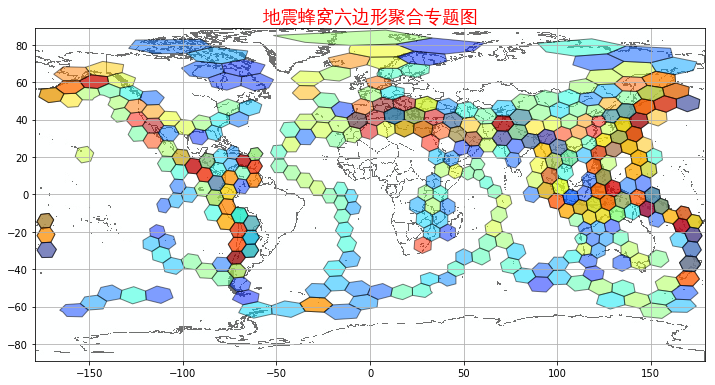

In [20]:
polyVal = []
for i in range(len(eqpd["cood"])):
    nxy = []
    for xy in eqpd["cood"][i]:
        nxy.append([xy[1],xy[0]])
    polyVal.append(((nxy),eqpd["num"][i]))
show(polyVal)

## 浅源地震区域

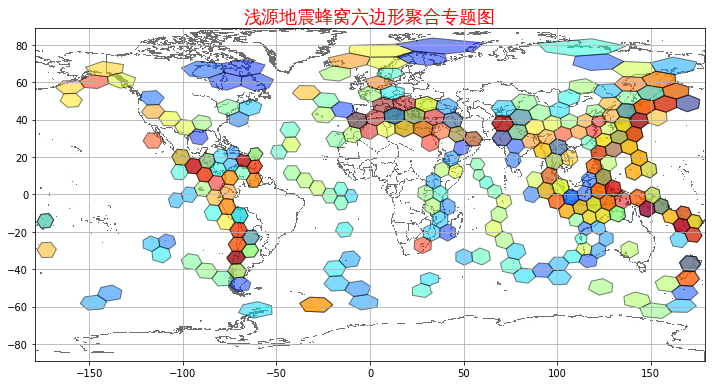

In [21]:
polyVal = []
res = eqpd[eqpd["eqtype"] == "shallow"]
for i in range(len(res["cood"])):
    nxy = []
    for xy in eqpd["cood"][i]:
        nxy.append([xy[1],xy[0]])
    polyVal.append(((nxy),eqpd["num"][i]))
show(polyVal,"浅源地震蜂窝六边形聚合专题图")

## 中源地震

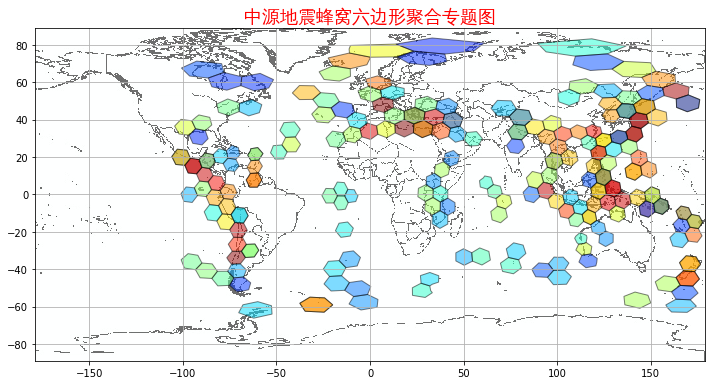

In [22]:
polyVal = []
res = eqpd[eqpd["eqtype"] == "Intermediate"]
for i in range(len(res["cood"])):
    nxy = []
    for xy in eqpd["cood"][i]:
        nxy.append([xy[1],xy[0]])
    polyVal.append(((nxy),eqpd["num"][i]))
show(polyVal,"中源地震蜂窝六边形聚合专题图")

## 深源地震

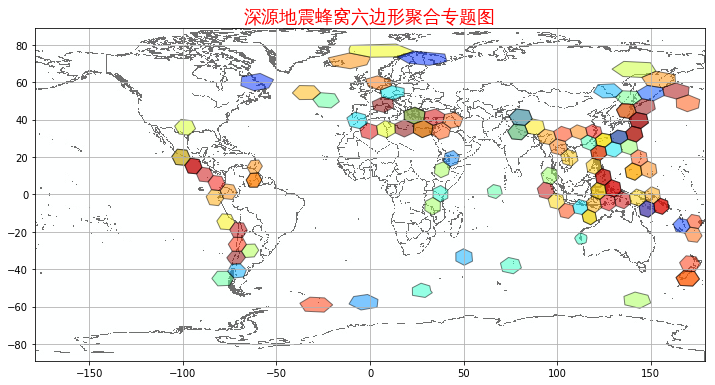

In [23]:
polyVal = []
res = eqpd[eqpd["eqtype"] == "palintectic"]
for i in range(len(res["cood"])):
    nxy = []
    for xy in eqpd["cood"][i]:
        nxy.append([xy[1],xy[0]])
    polyVal.append(((nxy),eqpd["num"][i]))
show(polyVal,"深源地震蜂窝六边形聚合专题图")